# Exploración de variables espaciales
<b>Proyecto</b>:	PDB IV - Pobreza urbana
<b>Objetivo</b>:    Desarrollo de variables espaciales y tabulaciones de pobreza con variables 

### 1. Bases de datos y librerías

In [1]:
import pandas as pd
import os
import numpy as np
import geopandas as gdp
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [2]:
os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\1. Bases\2. ENAHO Anual')

mod5 = pd.read_stata('modulo500.dta', convert_categoricals=False,
                     columns= ['anio', 'mes', 'conglome', 'vivienda','hogar', 'ubigeo', 'dominio', 'estrato',
                               'codperso', 'fac500a', 'p558d2_1', 'p558d2_2', 'ocupinf', 'i524a1', 'd529t',
                               'i530a', 'd536', 'i538a1', 'd540t', 'i541a', 'd543', 'd544t', 'p521a', 'p521',
                               'p519','i520', 'i513t', 'i518'])

sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,
                        columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'percepho', 'mieperho', 'gashog2d',
                                  'linpe', 'linea', 'gashog1d', 'pobrezav', 'pobreza', 'ipcr_0', 'gpgru0'])

mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
                     columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'latitud', 'longitud'])

mod2 = pd.read_stata('modulo200.dta', convert_categoricals=False,
                     columns=['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'codperso', 'p208a'])

dfEnaho = pd.merge(mod5, sumaria, how='inner', on=['anio', 'mes', 'conglome', 'vivienda', 'hogar'], validate="m:1")

dfEnaho = pd.merge(dfEnaho, mod1, how='inner', on=['anio', 'mes', 'conglome', 'vivienda', 'hogar'], validate="m:1")


C:\Users\User\AppData\Local\Temp\ipykernel_20664\3645476878.py:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  mod5 = pd.read_stata('modulo500.dta', convert_categoricals=False,
C:\Users\User\AppData\Local\Temp\ipykernel_20664\3645476878.py:9: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,
C:\Users\User\AppData\Local\Temp\ipykernel_20664\3645476878.py:13: UnicodeWarning: 
One or more strings in the dta file could not be decoded using ut

In [3]:
# Nos quedamos solo con las observaciones urbanas
dfUrb = dfEnaho[dfEnaho['estrato'] < 6]

## 2. Exploración distancia al trabajo y al centro de la ciudad

In [4]:
# Modificamos la variable p558d2_2 para ponerlo en formato ubigeo
dfUrb.loc[:,'p558d2_2'] = dfUrb['p558d2_2'].fillna('0')
dfUrb.loc[:,'p558d2_2'] = dfUrb['p558d2_2'].astype(int).astype(str).str.zfill(6)

C:\Users\User\AppData\Local\Temp\ipykernel_20664\830759936.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '0' '0' ... 150811.0 150811.0 '0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfUrb.loc[:,'p558d2_2'] = dfUrb['p558d2_2'].fillna('0')


#### 2.1. Residencia en distritos atractores de empleo

In [5]:
# Generamos la variable de pctResidencia
distResidencia = dfUrb.loc[:,['ubigeo','fac500a']].dropna()
distResidencia['provResidencia'] = (distResidencia['ubigeo'].astype(int) / 100).astype(int).astype(str).str.zfill(4)
distResidencia = distResidencia.dropna()

# Contabilizamos la cantidad de personas que residen por distrito
distResidencia = distResidencia.groupby(['provResidencia',"ubigeo"])['fac500a'].sum().reset_index()

distResidencia = distResidencia.rename(columns={'fac500a':'nPersonas'})
distResidencia['nPersonasProv'] = distResidencia.groupby('provResidencia')['nPersonas'].transform('sum')
distResidencia['pctResidencia'] = distResidencia['nPersonas'] / distResidencia['nPersonasProv']

In [6]:
# Generamos la variable ubigeo del centro de trabajo
dfUrb.loc[:,'ubigeoTrabajo'] = dfUrb.apply(lambda row: row['ubigeo'] if row['p558d2_1'] == 1 else row['p558d2_2'], axis=1)
dfUrb.loc[:,'ubigeoTrabajo'] = dfUrb['ubigeoTrabajo'].replace("000000", pd.NA).replace("999999", pd.NA)

C:\Users\User\AppData\Local\Temp\ipykernel_20664\3557774175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUrb.loc[:,'ubigeoTrabajo'] = dfUrb.apply(lambda row: row['ubigeo'] if row['p558d2_1'] == 1 else row['p558d2_2'], axis=1)


In [7]:
# Generamos la variable provincia del trabajo 
distTrabajo = dfUrb.loc[:,['ubigeoTrabajo','ubigeo','fac500a']].dropna()
distTrabajo['provTrabajo'] = (distTrabajo['ubigeoTrabajo'].astype(int) / 100).astype(int).astype(str).str.zfill(4)
distTrabajo = distTrabajo.dropna()

# Contabilizamos la cantidad de empleos que se generan
distTrabajo = distTrabajo.groupby(['provTrabajo',"ubigeoTrabajo"])['fac500a'].sum().reset_index()

In [8]:
distTrabajo = distTrabajo.rename(columns={'fac500a':'nTrabajos'})
distTrabajo['nTrabajosProv'] = distTrabajo.groupby('provTrabajo')['nTrabajos'].transform('sum')
distTrabajo['pctTrabajo'] = distTrabajo['nTrabajos'] / distTrabajo['nTrabajosProv']

In [9]:
# Definimos como centralidad si un distrito concentra atrae más trabajo que residentes.
distTrabajo = distTrabajo.rename(columns={'ubigeoTrabajo':'ubigeo'})
distUrb = pd.merge(distTrabajo, distResidencia, how='inner', on='ubigeo')
distUrb = distUrb.loc[:, ['ubigeo', 'pctResidencia', 'pctTrabajo']]

cond1 = (distUrb['pctTrabajo'] > distUrb['pctResidencia'] + 0.01 )
distUrb['distCentral'] = 0
distUrb.loc[ cond1 ,'distCentral'] = 1


#### 2.2. Distancia ecluidiana al trabajo

In [10]:
dfUrb = pd.merge(dfUrb, distUrb, how='left', on='ubigeo', validate="m:1")

cond2 = (dfUrb['pobreza'] < 3 )
dfUrb['pobre'] = 0
dfUrb.loc[ cond2 ,'pobre'] = 1
del cond2

In [11]:
tabla1 = pd.crosstab([dfUrb["anio"], dfUrb["distCentral"]], dfUrb["pobre"], values=dfUrb["fac500a"], aggfunc="sum", normalize='index')
tabla1.reset_index(inplace=True)
tabla1 = tabla1.drop(0, axis=1)

In [12]:
path_dist = "C:/Users/User/OneDrive - Universidad del Pacífico/1. Documentos/0. Bases de datos/11. Mapas Perú/Límite Distrital"

peru_dist = gdp.read_file(path_dist + "/LIMITE_DISTRITAL_2020_INEI_geogpsperu_juansuyo_931381206.shp")

var1 = peru_dist['UBIGEO']
var2 = peru_dist.centroid
var3 = var2.x
var4 = var2.y

centroids = pd.DataFrame({'p558d2_2': var1,
                          'x_long' : var3,
                          'y_lat' : var4})
del var1, var2, var3, var4

C:\Users\User\AppData\Local\Temp\ipykernel_20664\2172197495.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  var2 = peru_dist.centroid


In [13]:
dfUrb = pd.merge(dfUrb, centroids, how='left', on='p558d2_2', validate="m:1")

In [14]:
dfUrb2 = dfUrb[dfUrb['p558d2_2'] != '000000']
dfUrb2 = dfUrb2[dfUrb2['y_lat'].notna()]
dfUrb2 = dfUrb2.rename(columns={'y_lat':'lat_trabajo', 'x_long':'long_trabajo'})

In [15]:
dfUrb2 = dfUrb2.dropna(subset=['latitud', 'longitud', 'lat_trabajo', 'long_trabajo'])

dfUrb2.loc[:, 'distanciaTrabajo'] = dfUrb2.apply(lambda row: geodesic((row['latitud'], row['longitud']), (row['lat_trabajo'], row['long_trabajo'])).kilometers, axis=1)

#### 2.3. Distancia ecluidiana al centro de la ciudad

In [16]:
idx = distTrabajo.groupby(['provTrabajo'])['pctTrabajo'].idxmax()
distTrabajo2 = distTrabajo.loc[idx]
distTrabajo2 = distTrabajo2[['provTrabajo', 'ubigeo']]
distTrabajo2 = distTrabajo2.iloc[4:-1,:]

In [17]:
dfUrb2.loc[:,'prov'] = (dfUrb2['ubigeo'].astype(int) / 100).astype(int).astype(str).str.zfill(4)
distTrabajo2 = distTrabajo2.rename(columns={'provTrabajo':'prov'})

dfUrb2 = pd.merge(dfUrb2, distTrabajo2, how='left', on='prov', validate="m:1" )

In [18]:
dfUrb2 = dfUrb2.rename(columns={'ubigeo_y':'ubigeoCentro', 'ubigeo_x':'ubigeo'})

In [19]:
centroids = centroids.rename(columns={'p558d2_2':'ubigeoCentro',
                                      'y_lat':'lat_centro', 'x_long':'long_centro'})
dfUrb2 = pd.merge(dfUrb2, centroids, how='left', on='ubigeoCentro', validate="m:1")

In [20]:

dfUrb2 = dfUrb2[dfUrb2['anio'] >= 2018]

dfUrb2 = dfUrb2.dropna(subset=['latitud', 'longitud', 'lat_centro', 'long_centro'])

dfUrb2.loc[:, 'distanciaCentro'] = dfUrb2.apply(lambda row: geodesic((row['latitud'], row['longitud']), (row['lat_centro'], row['long_centro'])).kilometers, axis=1)


In [21]:
# Definir los límites de los intervalos
bins = [0, 5, 10, 20, 500]

# Definir los nombres de las categorías
labels = ['Menos de 5Km', 'Entre 5 y 10Km', 'Entre 10 y 20Km', 'Más de 20Km']

# Crear la nueva columna categórica
dfUrb2['catDistCentro'] = pd.cut(dfUrb2['distanciaCentro'], bins=bins, labels=labels, right=False)
dfUrb2['catDistTrabajo'] = pd.cut(dfUrb2['distanciaTrabajo'], bins=bins, labels=labels, right=False)


In [22]:
def weighted_mean(df, values, weights):
    return (df[values] * df[weights]).sum() / df[weights].sum()

pobLimaCentro = dfUrb2[dfUrb2['estrato'] == 1].groupby(['anio', 'catDistCentro']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))
pobEst2Centro = dfUrb2[dfUrb2['estrato'] == 2].groupby(['anio', 'catDistCentro']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))
pobRestoCentro = dfUrb2[dfUrb2['estrato'] > 2].groupby(['anio', 'catDistCentro']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))

pobLimaTrabajo = dfUrb2[dfUrb2['estrato'] == 1].groupby(['anio', 'catDistTrabajo']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))
pobEst2Trabajo = dfUrb2[dfUrb2['estrato'] == 2].groupby(['anio', 'catDistTrabajo']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))
pobRestoTrabajo = dfUrb2[dfUrb2['estrato'] > 2].groupby(['anio', 'catDistTrabajo']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))

C:\Users\User\AppData\Local\Temp\ipykernel_20664\4250613087.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pobLimaCentro = dfUrb2[dfUrb2['estrato'] == 1].groupby(['anio', 'catDistCentro']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))
C:\Users\User\AppData\Local\Temp\ipykernel_20664\4250613087.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobLimaCentro = dfUrb2[dfUrb2['estrato'] == 1].groupby(['anio', 'catDistCentro']).apply(lambda x: weighted_mean(x, 'pobre', 'fac500a'))
C:\Users\User\App

## 3. Exploración distancia a escuelas públicas

In [23]:
os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\1. Bases')

dfIIEE = pd.read_csv('listado_iiee.csv')
dfIIEE.loc[:,'Ubigeo'] = dfIIEE['Ubigeo'].astype(str).str.zfill(6)
dfIIEE.loc[:,'tipoGestion'] = dfIIEE['Gestion / Dependencia'].str[:7]


C:\Users\User\AppData\Local\Temp\ipykernel_20664\815276184.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['010101' '010101' '010101' ... '250401' '250401' '250401']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfIIEE.loc[:,'Ubigeo'] = dfIIEE['Ubigeo'].astype(str).str.zfill(6)


In [24]:
os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\1. Bases\2. ENAHO Anual')
mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
                     columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'latitud', 'longitud', 'estrato', 'ubigeo','factor07'])
mod1 = pd.merge(mod1, sumaria, how='inner', on=['anio', 'mes', 'conglome', 'vivienda', 'hogar'], validate="1:1")

C:\Users\User\AppData\Local\Temp\ipykernel_20664\74732141.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,


In [25]:
cond1 = mod1['estrato'] < 6
cond2 = mod1['anio'] >= 2018
mod1 = mod1[cond1 & cond2]

In [26]:
distUrb2 = pd.Series(mod1['ubigeo'].unique(), name='Ubigeo')
dfIEUrb = pd.merge(distUrb2, dfIIEE, on='Ubigeo')
dfIEUrb = dfIEUrb[dfIEUrb['tipoGestion'] == 'Pública']
del distUrb2

In [27]:
dfIEUrb = dfIEUrb.rename(columns={'Ubigeo':'ubigeo'})
dfIEUrb = pd.merge(mod1, dfIEUrb, on='ubigeo', how='inner' , validate='m:m')

In [28]:
dfIEUrb = dfIEUrb.rename(columns={'latitud':'latCong',
                        'longitud' : 'longCong',
                        'Latitud': 'latIE',
                        'Longitud': 'longIE'})

dfIEUrb = dfIEUrb.dropna(subset=['latCong', 'longCong', 'latIE', 'longIE'])

dfIEUrb.loc[:, 'distanciaIE'] = dfIEUrb.apply(lambda row: geodesic((row['latCong'], row['longCong']), (row['latIE'], row['longIE'])).kilometers, axis=1)

In [29]:
dfIEUrb['ID'] = dfIEUrb['anio'].astype(str) + '_' + dfIEUrb['mes'].astype(str) + '_' + dfIEUrb['conglome'].astype(str) + '_' + dfIEUrb['vivienda'].astype(str) + '_' + dfIEUrb['hogar'].astype(str) 

In [30]:
dfIEUrb2 = dfIEUrb.groupby(['ID', 'anio', 'mes', 'conglome', 'vivienda', 'hogar', 'pobreza', 'factor07']).min('distanciaIE')
dfIEUrb2 = dfIEUrb2.reset_index()

In [31]:
# Definir los límites de los intervalos
bins = [0, 0.5, 1, 2.5, 500]

# Definir los nombres de las categorías
labels = ['Menos de 500m', 'Entre 0.5 y 1Km', 'Entre 1 y 2.5 Km', 'Más de 2.5Km']

# Crear la nueva columna categórica
dfIEUrb2['catDistIE'] = pd.cut(dfIEUrb2['distanciaIE'], bins=bins, labels=labels, right=False)

In [32]:
def weighted_mean(df, values, weights):
    return (df[values] * df[weights]).sum() / df[weights].sum()

In [33]:
dfIEUrb2['pobre'] = dfIEUrb2['pobreza']<3

pobLimaIE = dfIEUrb2[dfIEUrb2['estrato'] == 1].groupby(['anio', 'catDistIE']).apply(lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2IE = dfIEUrb2[dfIEUrb2['estrato'] == 2].groupby(['anio', 'catDistIE']).apply(lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoIE = dfIEUrb2[dfIEUrb2['estrato'] > 2].groupby(['anio', 'catDistIE']).apply(lambda x: weighted_mean(x, 'pobre', 'factor07'))


C:\Users\User\AppData\Local\Temp\ipykernel_20664\2249214039.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pobLimaIE = dfIEUrb2[dfIEUrb2['estrato'] == 1].groupby(['anio', 'catDistIE']).apply(lambda x: weighted_mean(x, 'pobre', 'factor07'))
C:\Users\User\AppData\Local\Temp\ipykernel_20664\2249214039.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobLimaIE = dfIEUrb2[dfIEUrb2['estrato'] == 1].groupby(['anio', 'catDistIE']).apply(lambda x: weighted_mean(x, 'pobre', 'factor07'))
C:\Users\User\AppData\L

## 4. Exploración distancia a comisarías

In [34]:
pathCom = "C:/Users/User/OneDrive - Universidad del Pacífico/1. Documentos/0. Bases de datos/11. Mapas Perú/comisarias_shapefile"

peruCom = gdp.read_file(pathCom + "/comisarias_fuente_cenepred.shp")

In [35]:
comisarias = peruCom.centroid

var1 = peruCom['nombre']
var2 = peruCom['dpto']
var3 = peruCom['dist']
var4 = peruCom['prov']
xCom = comisarias.x
yCom = comisarias.y
comisarias = pd.DataFrame({'nombreCom': var1,
                          'xCom' : xCom,
                          'yCom' : yCom,
                           'distCom' : var3,
                           'provCom' : var4,
                           'dptoCom' : var2})

del var1, xCom, yCom, var2, var3, var4

C:\Users\User\AppData\Local\Temp\ipykernel_20664\3087554850.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comisarias = peruCom.centroid


In [36]:
comisarias.loc[comisarias['dptoCom'] == "AMAZONAS - CAJAMARCA",'dptoCom'] = "AMAZONAS"
comisarias.loc[comisarias['dptoCom'] == "AMAZONAS - SAN MARTIN",'dptoCom'] = "AMAZONAS"
comisarias.loc[comisarias['dptoCom'] == "JUNIN",'dptoCom']  = "JUNÍN"

comisarias = comisarias.sort_values(by='dptoCom')
comisarias['CCDD'], unique = pd.factorize(comisarias['dptoCom'])
comisarias['CCDD'] = comisarias['CCDD'] + 1

In [37]:
comisarias.loc[:,'CCDD'] = comisarias.loc[:,'CCDD'].astype(int).astype(str).str.zfill(2)

C:\Users\User\AppData\Local\Temp\ipykernel_20664\1274969275.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['01' '01' '01' ... '25' '25' '25']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  comisarias.loc[:,'CCDD'] = comisarias.loc[:,'CCDD'].astype(int).astype(str).str.zfill(2)


In [38]:
mod1.loc[:,'CCDD'] = (mod1.loc[:,'ubigeo'].astype(int)/10000).astype(int).astype(str).str.zfill(2)

In [39]:
mod1Com = pd.merge(mod1, comisarias, on = 'CCDD', how= 'inner', validate = 'm:m')

In [40]:
mod1Com = mod1Com.rename(columns={'latitud': 'latCong',
                                  'longitud': 'longCong',
                                  'yCom': 'latCom',
                                  'xCom': 'longCom'})

mod1Com = mod1Com.dropna(subset=['latCong', 'longCong', 'latCom', 'longCom'])

mod1Com.loc[:, 'distanciaCom'] = mod1Com.apply(
    lambda row: geodesic((row['latCong'], row['longCong']), (row['latCom'], row['longCom'])).kilometers, axis=1)

In [41]:
mod1Com2 = mod1Com.groupby(['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'pobreza', 'factor07']).min(
    'distanciaCom')
mod1Com2 = mod1Com2.reset_index()

In [42]:
# Definir los límites de los intervalos
bins = [0, 0.5, 1, 2.5, 500]

# Definir los nombres de las categorías
labels = ['Menos de 500m', 'Entre 0.5 y 1Km', 'Entre 1 y 2.5 Km', 'Más de 2.5Km']

# Crear la nueva columna categórica
mod1Com2['catDistCom'] = pd.cut(mod1Com2['distanciaCom'], bins=bins, labels=labels, right=False)


In [43]:
mod1Com2['pobre'] = mod1Com2['pobreza'] < 3

pobLimaCom = mod1Com2[mod1Com2['estrato'] == 1].groupby(['anio', 'catDistCom']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2Com = mod1Com2[mod1Com2['estrato'] == 2].groupby(['anio', 'catDistCom']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoCom = mod1Com2[mod1Com2['estrato'] > 2].groupby(['anio', 'catDistCom']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))

C:\Users\User\AppData\Local\Temp\ipykernel_20664\3160147013.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pobLimaCom = mod1Com2[mod1Com2['estrato'] == 1].groupby(['anio', 'catDistCom']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\3160147013.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobLimaCom = mod1Com2[mod1Com2['estrato'] == 1].groupby(['anio', 'catDistCom']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\3160147013.py:5: FutureWarning: The default of observed=False is d

## 5. Exploración distancia a EE.SS.

In [44]:
sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,
                        columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'percepho', 'mieperho', 'gashog2d',
                                  'linpe', 'linea', 'gashog1d', 'pobrezav', 'pobreza', 'ipcr_0', 'gpgru0'])

mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
                     columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'latitud', 'longitud'])

mod4 = pd.read_stata('modulo400.dta', convert_categoricals=False,
                     columns= ['anio', 'mes', 'conglome', 'vivienda','hogar', 'ubigeo', 'dominio', 'estrato', 'codperso', 'factor07', 'p407g1', 'p407g2', 'p407g3'])

C:\Users\User\AppData\Local\Temp\ipykernel_20664\3133766904.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,
C:\Users\User\AppData\Local\Temp\ipykernel_20664\3133766904.py:5: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
C:\Users\User\AppData\Local\Temp\ipykernel_20664\3133766904.py:8: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf

In [45]:
cond1 = mod4['estrato'] < 6
cond2 = mod4['anio'] >= 2018
mod4 = mod4[cond1 & cond2]

In [46]:
mod4 = pd.merge(mod4, mod1, on=['anio', 'mes', 'conglome', 'vivienda', 'hogar'], how='inner', validate='m:1')
mod4 = pd.merge(mod4, sumaria, on=['anio', 'mes', 'conglome', 'vivienda', 'hogar'], how='inner', validate='m:1')

### Según ubicación de CCSS público más cercano

In [47]:
os.chdir(
    r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\1. Bases')

dfCCSS = pd.read_excel('listado_ccss.xls')
dfCCSS.loc[:, 'UBIGEO'] = dfCCSS.loc[:, 'UBIGEO'].astype(str).str.zfill(6)

C:\Users\User\AppData\Local\Temp\ipykernel_20664\806280656.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['150134' '070106' '250101' ... '050408' '090117' '150110']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfCCSS.loc[:, 'UBIGEO'] = dfCCSS.loc[:, 'UBIGEO'].astype(str).str.zfill(6)


In [48]:
cond = (dfCCSS['Institución'] == 'GOBIERNO REGIONAL') | (dfCCSS['Institución'] == 'MINSA') | (dfCCSS['Institución'] == 'MUNICIPALIDAD PROVINCIAL') | (dfCCSS['Institución'] == 'MUNICIPALIDAD DISTRITAL')
dfCCSSMINSAGR = dfCCSS[cond]

In [49]:
dfCCSSMINSAGR = dfCCSSMINSAGR[dfCCSSMINSAGR['NORTE'].notna()]
dfCCSSMINSAGR = dfCCSSMINSAGR.rename(columns={'NORTE' : 'lat_ccss',
                                              'ESTE' : 'long_ccss',
                                              'UBIGEO' : 'ubigeo'})

In [50]:
mod4CCSS = pd.merge(mod4, dfCCSSMINSAGR, on=['ubigeo'], how= 'inner', validate='m:m')

mod4CCSS = mod4CCSS.rename(columns={'latitud': 'latCong',
                                    'longitud': 'longCong'})
mod4CCSS = mod4CCSS[mod4CCSS['latCong'].notna()]


In [51]:
mod4CCSS.loc[:, 'distanciaCCSS'] = mod4CCSS.apply(lambda row: geodesic((row['latCong'], row['longCong']), (row['lat_ccss'], row['long_ccss'])).kilometers, axis=1)

In [52]:
condI = (mod4CCSS['Categoria'] == 'I-1') | (mod4CCSS['Categoria'] == 'I-2') | (mod4CCSS['Categoria'] == 'I-3') | (mod4CCSS['Categoria'] == 'I-4')
condII = (mod4CCSS['Categoria'] == 'II-E') | (mod4CCSS['Categoria'] == 'II-1') | (mod4CCSS['Categoria'] == 'II-2')

mod4CCSS_I = mod4CCSS[condI].groupby(['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'codperso', 'pobreza', 'factor07']).min('distanciaCCSS')
mod4CCSS_II = mod4CCSS[condII].groupby(['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'codperso', 'pobreza', 'factor07']).min('distanciaCCSS')
mod4CCSS_I = mod4CCSS_I.reset_index()
mod4CCSS_II = mod4CCSS_II.reset_index()

mod4CCSS_I_II = mod4CCSS[condI | condII].groupby(['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'codperso', 'pobreza', 'factor07']).min('distanciaCCSS')
mod4CCSS_I_II = mod4CCSS_I_II.reset_index()


In [53]:
# Definir los límites de los intervalos
bins = [0, 0.5, 1, 2.5, 500]

# Definir los nombres de las categorías
labels = ['Menos de 500m', 'Entre 0.5 y 1Km', 'Entre 1 y 2.5 Km', 'Más de 2.5Km']

# Crear la nueva columna categórica
mod4CCSS_I['catDistCCSS_I'] = pd.cut(mod4CCSS_I['distanciaCCSS'], bins=bins, labels=labels, right=False)
mod4CCSS_II['catDistCCSS_II'] = pd.cut(mod4CCSS_II['distanciaCCSS'], bins=bins, labels=labels, right=False)
mod4CCSS_I_II['catDistCCSS_I_II'] = pd.cut(mod4CCSS_I_II['distanciaCCSS'], bins=bins, labels=labels, right=False)


In [54]:
mod4CCSS_I['pobre'] = mod4CCSS_I['pobreza'] < 3

pobLimaCCSS_I = mod4CCSS_I[mod4CCSS_I['estrato'] == 1].groupby(['anio', 'catDistCCSS_I']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2CCSS_I = mod4CCSS_I[mod4CCSS_I['estrato'] == 2].groupby(['anio', 'catDistCCSS_I']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoCCSS_I = mod4CCSS_I[mod4CCSS_I['estrato'] > 2].groupby(['anio', 'catDistCCSS_I']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))


mod4CCSS_II['pobre'] = mod4CCSS_II['pobreza'] < 3

pobLimaCCSS_II = mod4CCSS_II[mod4CCSS_II['estrato'] == 1].groupby(['anio', 'catDistCCSS_II']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2CCSS_II = mod4CCSS_II[mod4CCSS_II['estrato'] == 2].groupby(['anio', 'catDistCCSS_II']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoCCSS_II = mod4CCSS_II[mod4CCSS_II['estrato'] > 2].groupby(['anio', 'catDistCCSS_II']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))

mod4CCSS_I_II['pobre'] = mod4CCSS_I_II['pobreza'] < 3

pobLimaCCSS_I_II = mod4CCSS_I_II[mod4CCSS_I_II['estrato'] == 1].groupby(['anio', 'catDistCCSS_I_II']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2CCSS_I_II = mod4CCSS_I_II[mod4CCSS_I_II['estrato'] == 2].groupby(['anio', 'catDistCCSS_I_II']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoCCSS_I_II = mod4CCSS_I_II[mod4CCSS_I_II['estrato'] > 2].groupby(['anio', 'catDistCCSS_I_II']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))

C:\Users\User\AppData\Local\Temp\ipykernel_20664\1385978869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pobLimaCCSS_I = mod4CCSS_I[mod4CCSS_I['estrato'] == 1].groupby(['anio', 'catDistCCSS_I']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\1385978869.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobLimaCCSS_I = mod4CCSS_I[mod4CCSS_I['estrato'] == 1].groupby(['anio', 'catDistCCSS_I']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\1385978869.py:5: FutureWarning: The default of

### Según INEI

In [55]:
mod4 = mod4[mod4['p407g1'].notna()]

In [56]:
mod4.loc[:, 'tiempoCCSS'] = mod4.apply(lambda row: row['p407g1']*24*60 + row['p407g2']*60 + row['p407g3'], axis=1)

In [57]:
# Definir los límites de los intervalos
bins = [0, 45, 90, 180, 22000]

# Definir los nombres de las categorías
labels = ['Menos de 0.5h', 'Entre 0.5 y 1.5h', 'Entre 1.5 y 3h', 'Más de 3h']

# Crear la nueva columna categórica
mod4['catDistCCSS1'] = pd.cut(mod4['tiempoCCSS'], bins=bins, labels=labels, right=False)

In [58]:
mod4['pobre'] = mod4['pobreza'] < 3

pobLimaCCSS1 = mod4[mod4['estrato'] == 1].groupby(['anio', 'catDistCCSS1']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2CCSS1 = mod4[mod4['estrato'] == 2].groupby(['anio', 'catDistCCSS1']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoCCSS1 = mod4[mod4['estrato'] > 2].groupby(['anio', 'catDistCCSS1']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))

C:\Users\User\AppData\Local\Temp\ipykernel_20664\4233932398.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pobLimaCCSS1 = mod4[mod4['estrato'] == 1].groupby(['anio', 'catDistCCSS1']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\4233932398.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobLimaCCSS1 = mod4[mod4['estrato'] == 1].groupby(['anio', 'catDistCCSS1']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\4233932398.py:5: FutureWarning: The default of observed=False is deprecate

## 6. Exploración distancia a Mercados de abastos 

In [59]:
mercados = pd.read_stata(r'C:\Users\User\Downloads\554-Modulo1116\Capítulo_I_NACIONAL.dta')
mercados.loc[:, 'ubigeo'] = mercados.loc[:, 'CCDD'] + mercados.loc[:, 'CCPP'] + mercados.loc[:,'CCDI']
mercados = mercados.loc[:,['ubigeo', 'GPS_LAT', 'GPS_LON']]

mercados.loc[:, 'GPS_LAT'] = mercados.loc[:, 'GPS_LAT'].str.replace(',', '.').astype(float)
mercados.loc[:, 'GPS_LON'] = mercados.loc[:, 'GPS_LON'].str.replace(',', '.').astype(float)

In [60]:
def corregir_valor_lat(x):
    if x > 20 or x < -20:
        x_str = str(abs(int(x)))  # Convertir a string el valor absoluto y quitar decimales
        # Detectar si hay que dividir por 10, 100, 1000, etc.
        for i in range(1, len(x_str)):
            divisor = 10 ** i
            if abs(x) / divisor <= 20:
                return x / divisor
    return x

def corregir_valor_long(x):
    if x > 20 or x < -85:
        x_str = str(abs(int(x)))  # Convertir a string el valor absoluto y quitar decimales
        # Detectar si hay que dividir por 10, 100, 1000, etc.
        for i in range(1, len(x_str)):
            divisor = 10 ** i
            if abs(x) / divisor <= 85:
                return x / divisor
    return x

mercados.loc[:, 'GPS_LAT'] = pd.to_numeric(mercados.loc[:, 'GPS_LAT'])
mercados.loc[:, 'GPS_LAT'] = mercados.loc[:, 'GPS_LAT'].apply(corregir_valor_lat)

mercados.loc[:, 'GPS_LON'] = pd.to_numeric(mercados.loc[:, 'GPS_LON'])
mercados.loc[:, 'GPS_LON'] = mercados.loc[:, 'GPS_LON'].apply(corregir_valor_long)

In [61]:
os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\1. Bases\2. ENAHO Anual')
mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
                     columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'latitud', 'longitud', 'estrato', 'ubigeo','factor07'])
sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,
                        columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'percepho', 'mieperho', 'gashog2d', 'linpe', 'linea', 'gashog1d', 'pobrezav', 'pobreza', 'ipcr_0', 'gpgru0'])

mod1 = pd.merge(mod1, sumaria, how='inner', on=['anio', 'mes', 'conglome', 'vivienda', 'hogar'], validate="1:1")

C:\Users\User\AppData\Local\Temp\ipykernel_20664\689423368.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
C:\Users\User\AppData\Local\Temp\ipykernel_20664\689423368.py:4: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,


In [62]:
cond1 = mod1['estrato'] < 6
cond2 = mod1['anio'] >= 2018
mod1 = mod1[cond1 & cond2]

In [63]:
mod1Mercados = pd.merge(mod1, mercados, on='ubigeo', how='inner', validate='m:m')
mod1Mercados = mod1Mercados.rename(columns={'latitud': 'latCong',
                                            'longitud': 'longCong',
                                            'GPS_LAT': 'latMer',
                                            'GPS_LON': 'longMer'})

mod1Mercados = mod1Mercados.dropna(subset=['latCong', 'longCong', 'latMer', 'longMer'])

In [64]:
mod1Mercados.loc[:, 'distanciaMercado'] = mod1Mercados.apply(
    lambda row: geodesic((row['latCong'], row['longCong']), (row['latMer'], row['longMer'])).kilometers, axis=1)

In [65]:
mod1Mercados = mod1Mercados.groupby(['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'pobreza', 'factor07']).min(
    'distanciaMercado')
mod1Mercados = mod1Mercados.reset_index()

In [66]:
# Definir los límites de los intervalos
bins = [0, 0.5, 1, 2.5, 500]

# Definir los nombres de las categorías
labels = ['Menos de 500m', 'Entre 0.5 y 1Km', 'Entre 1 y 2.5 Km', 'Más de 2.5Km']

# Crear la nueva columna categórica
mod1Mercados['catDistMer'] = pd.cut(mod1Mercados['distanciaMercado'], bins=bins, labels=labels, right=False)

In [67]:
mod1Mercados['pobre'] = mod1Mercados['pobreza'] < 3

def weighted_mean(df, values, weights):
    return (df[values] * df[weights]).sum() / df[weights].sum()

pobLimaMer = mod1Mercados[mod1Mercados['estrato'] == 1].groupby(['anio', 'catDistMer']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2Mer = mod1Mercados[mod1Mercados['estrato'] == 2].groupby(['anio', 'catDistMer']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoMer = mod1Mercados[mod1Mercados['estrato'] > 2].groupby(['anio', 'catDistMer']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))

C:\Users\User\AppData\Local\Temp\ipykernel_20664\800062744.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pobLimaMer = mod1Mercados[mod1Mercados['estrato'] == 1].groupby(['anio', 'catDistMer']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\800062744.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobLimaMer = mod1Mercados[mod1Mercados['estrato'] == 1].groupby(['anio', 'catDistMer']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\800062744.py:8: FutureWarning: The default of observ

## 7. Exploración - World Bank - Light Every Night

In [68]:
os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\1. Bases\2. ENAHO Anual')
mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
                     columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'latitud', 'longitud', 'estrato', 'ubigeo','factor07'])
sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,
                        columns= ['anio', 'mes', 'conglome', 'vivienda', 'hogar', 'percepho', 'mieperho', 'gashog2d', 'linpe', 'linea', 'gashog1d', 'pobrezav', 'pobreza', 'ipcr_0', 'gpgru0'])

mod1 = pd.merge(mod1, sumaria, how='inner', on=['anio', 'mes', 'conglome', 'vivienda', 'hogar'], validate="1:1")

C:\Users\User\AppData\Local\Temp\ipykernel_20664\689423368.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  mod1 = pd.read_stata('modulo100.dta', convert_categoricals=False,
C:\Users\User\AppData\Local\Temp\ipykernel_20664\689423368.py:4: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  sumaria = pd.read_stata('sumaria.dta', convert_categoricals=False,


In [69]:
cond1 = mod1['estrato'] < 6
cond2 = mod1['anio'] >= 2018
mod1 = mod1[cond1 & cond2]

In [70]:
import ee
import geemap
import pandas as pd

# Inicializar Google Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [71]:
# Definir la colección de imágenes y los años de interés
colID = "NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG"
start = 2018
end = 2022

years = ee.List.sequence(start, end)

In [72]:
# Función para reducir las imágenes anuales a una mediana
def viirs_annual_median_reduce(year):
    return ee.ImageCollection(colID).filter(
        ee.Filter.calendarRange(year, year, "year")).select("avg_rad").median().set('year', year)

In [73]:
# Mapear la función sobre la lista de años
yearComps = ee.ImageCollection.fromImages(years.map(viirs_annual_median_reduce))

# Inicializar un diccionario para almacenar los resultados
data = {'Year': [], 'Average Radiation': []}

In [74]:
mod1 = mod1[mod1['anio'] != 2023]

In [ ]:
coords = mod1.loc[:,['anio','conglome','latitud','longitud']].drop_duplicates()

In [ ]:
# Esto lo corrí en Google Colab y lo exporté en csv para luego poder juntarlo a la base completa aquí
def get_avg_rad(row):
    year = row['anio']
    lat_cong = row['latitud']
    long_cong = row['longitud']

    # Filter the image by year
    img = yearComps.filterMetadata("year", "equals", year).first()

    if not img:
        return None

    # Get the average radiance value
    avg_rad = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee.Geometry.Point(long_cong, lat_cong).buffer(1000),
        scale=1000
    ).getInfo().get('avg_rad', None)  # Default to None if 'avg_rad' is not found

    return avg_rad

#coords['avg_rad'] = coords.apply(get_avg_rad, axis=1)

In [75]:
os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\1. Bases')

avg_rad_500 = pd.read_csv('avg_rad_500.csv')
avg_rad_1000 = pd.read_csv('avg_rad_1000.csv')

coords = pd.merge(avg_rad_500, avg_rad_1000, on = ['anio', 'conglome', 'latitud', 'longitud'], how= 'inner')
coords = coords.rename(columns = {'avg_rad_x':'avg_rad_500',
                                  'avg_rad_y':'avg_rad_1000'})

coords.loc[:,'conglome'] = coords.loc[:,'conglome'].astype(str).str.zfill(6)

mod1 = pd.merge(mod1, coords, on = ['anio', 'conglome'], how = 'inner', validate= 'm:1')

C:\Users\User\AppData\Local\Temp\ipykernel_20664\1886383593.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['010309' '008815' '008807' ... '020551' '020552' '020553']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  coords.loc[:,'conglome'] = coords.loc[:,'conglome'].astype(str).str.zfill(6)


In [76]:
mod1['catDistRad500'] = pd.qcut(mod1['avg_rad_500'], 5, labels=False) + 1
mod1['catDistRad1000'] = pd.qcut(mod1['avg_rad_1000'], 5, labels=False) + 1

In [77]:
mod1['pobre'] = mod1['pobreza'] < 3

def weighted_mean(df, values, weights):
    return (df[values] * df[weights]).sum() / df[weights].sum()

pobLimaRad1000 = mod1[mod1['estrato'] == 1].groupby(['anio', 'catDistRad1000']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2Rad1000 = mod1[mod1['estrato'] == 2].groupby(['anio', 'catDistRad1000']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoRad1000 = mod1[mod1['estrato'] > 2].groupby(['anio', 'catDistRad1000']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))

pobLimaRad500 = mod1[mod1['estrato'] == 1].groupby(['anio', 'catDistRad500']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobEst2Rad500 = mod1[mod1['estrato'] == 2].groupby(['anio', 'catDistRad500']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))
pobRestoRad500 = mod1[mod1['estrato'] > 2].groupby(['anio', 'catDistRad500']).apply(
    lambda x: weighted_mean(x, 'pobre', 'factor07'))

C:\Users\User\AppData\Local\Temp\ipykernel_20664\1739900890.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobLimaRad1000 = mod1[mod1['estrato'] == 1].groupby(['anio', 'catDistRad1000']).apply(
C:\Users\User\AppData\Local\Temp\ipykernel_20664\1739900890.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pobEst2Rad1000 = mod1[mod1['estrato'] == 2].groupby(['anio', 'catDistRad1000']).apply(
C:\Users\Use

## 8. Generación de cuadros resumen

In [78]:
dataframe_names = ['IE', 'CCSS1', 'CCSS_I_II', 'CCSS_I', 'CCSS_II', 'Centro', 'Com', 'Mer', 'Trabajo', 'Rad500', 'Rad1000']

# Función para procesar y renombrar DataFrames
def process_dataframe(df, new_col, dist_col):
    df = df.reset_index()
    df = df.rename(columns={0: new_col, 'index': dist_col})  # Renombramos la columna dinámica
    return df

# Crear un diccionario para almacenar los DataFrames procesados
processed_dataframes = {
    'Lima': {},
    'Est2': {},
    'Resto': {}
}

# Procesar los DataFrames y almacenarlos en el diccionario
for name in dataframe_names:
    processed_dataframes['Lima'][name] = process_dataframe(eval(f'pobLima{name}'), 'Lima', f'catDist{name}')
    processed_dataframes['Est2'][name] = process_dataframe(eval(f'pobEst2{name}'), 'Est2', f'catDist{name}')
    processed_dataframes['Resto'][name] = process_dataframe(eval(f'pobResto{name}'), 'Resto', f'catDist{name}')

# Función para fusionar los DataFrames
def merge_dataframes(df1, df2, df3, dist_col):
    merged_df = pd.merge(df1, df2, how='inner', on=['anio', dist_col], validate='1:1')
    merged_df = pd.merge(merged_df, df3, how='inner', on=['anio', dist_col], validate='1:1')
    return merged_df

# Crear un diccionario para almacenar los DataFrames fusionados
merged_dataframes = {}

# Fusionar los DataFrames y almacenarlos en el diccionario
for name in dataframe_names:
    merged_dataframes[name] = merge_dataframes(
        processed_dataframes['Lima'][name],
        processed_dataframes['Est2'][name],
        processed_dataframes['Resto'][name],
        f'catDist{name}'
    )

# Acceder a un DataFrame fusionado específico
distIE = merged_dataframes['IE']
distCCSS1 = merged_dataframes['CCSS1']
distCCSS_I_II = merged_dataframes['CCSS_I_II']
distCCSS_I = merged_dataframes['CCSS_I']
distCCSS_II = merged_dataframes['CCSS_II']
distCentro = merged_dataframes['Centro']
distCom = merged_dataframes['Com']
distMer = merged_dataframes['Mer']
distRad500 = merged_dataframes['Rad500']
distRad1000 = merged_dataframes['Rad1000']
distTrabajo = merged_dataframes['Trabajo']

In [79]:
os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\2. Output')

dataframe_names = ['IE', 'CCSS1', 'CCSS_I_II', 'CCSS_I', 'CCSS_II', 'Centro', 'Com', 'Mer', 'Trabajo', 'Rad500', 'Rad1000']

file_path = 'analisisEspacial.xlsx'
with pd.ExcelWriter(file_path) as writer:
    for data in dataframe_names:
        df = merged_dataframes[data]
        df.to_excel(writer, sheet_name=data, index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_20664\869301118.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2018' '2018' '2018' '2022' '2022' '2022' '2018' '2018' '2018' '2022'
 '2022' '2022' '2018' '2018' '2018' '2022' '2022' '2022']' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_melt.loc[:,'anio'] = df_melt.loc[:,'anio'].astype(int).astype(str)
C:\Users\User\AppData\Local\Temp\ipykernel_20664\869301118.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2018' '2018' '2018' '2018' '2022' '2022' '2022' '2022' '2018' '2018'
 '2018' '2018' '2022' '2022' '2022' '2022' '2018' '2018' '2018' '2018'
 '2022' '2022' '2022' '2022']' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_melt.loc[:,'anio'] = df_melt.loc[:,'anio'].astype(int).astype(str)
C:\User

<Figure size 1200x600 with 0 Axes>

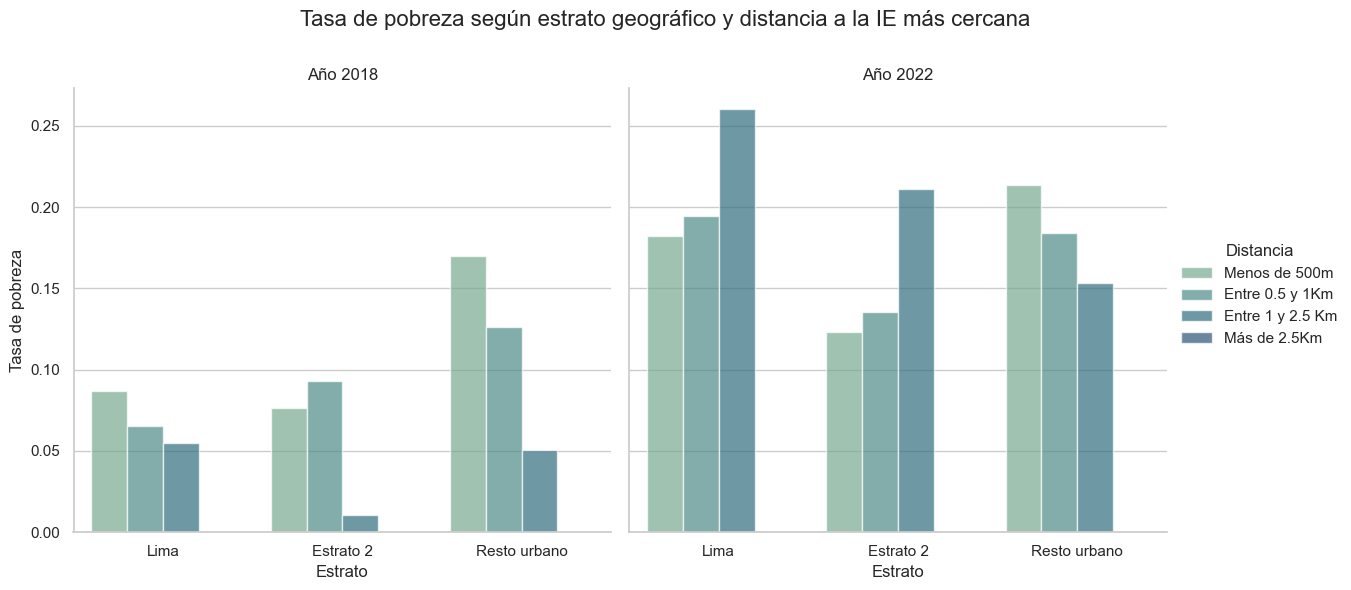

<Figure size 1200x600 with 0 Axes>

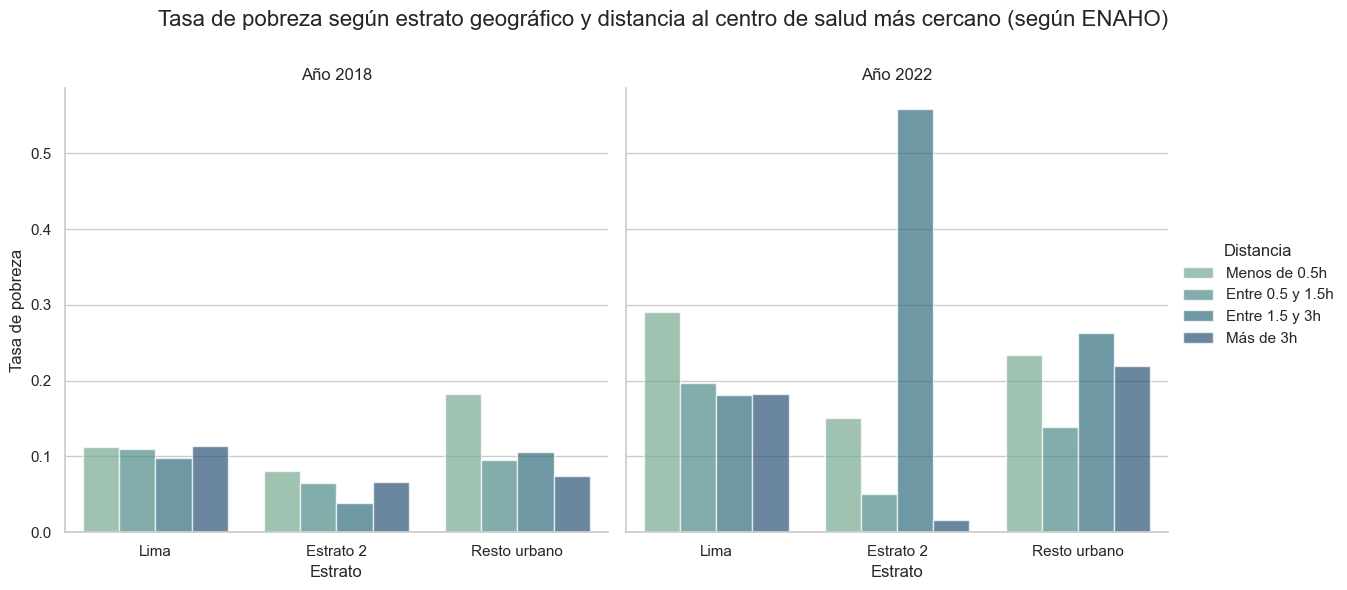

<Figure size 1200x600 with 0 Axes>

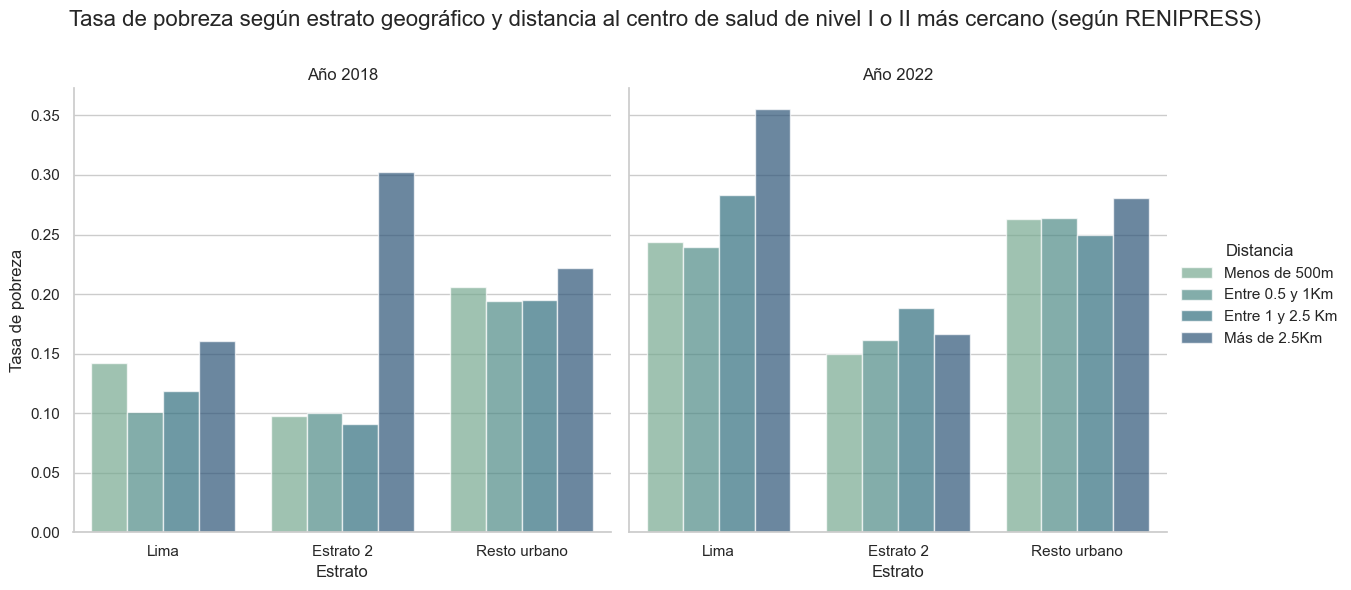

<Figure size 1200x600 with 0 Axes>

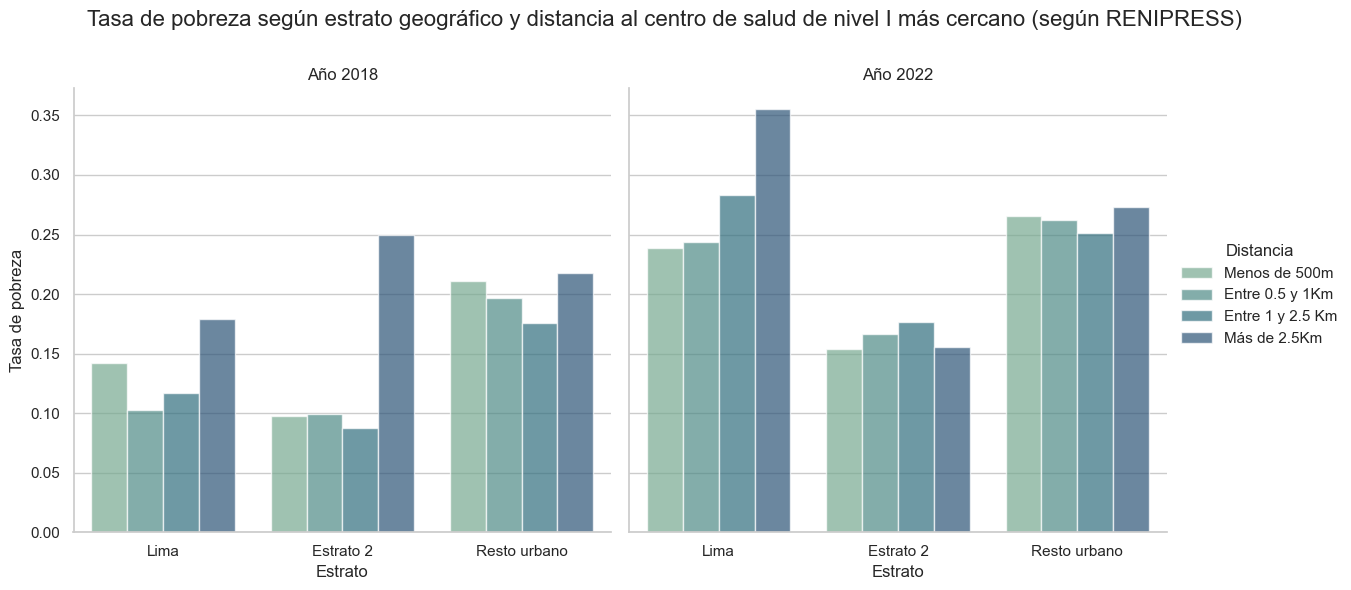

<Figure size 1200x600 with 0 Axes>

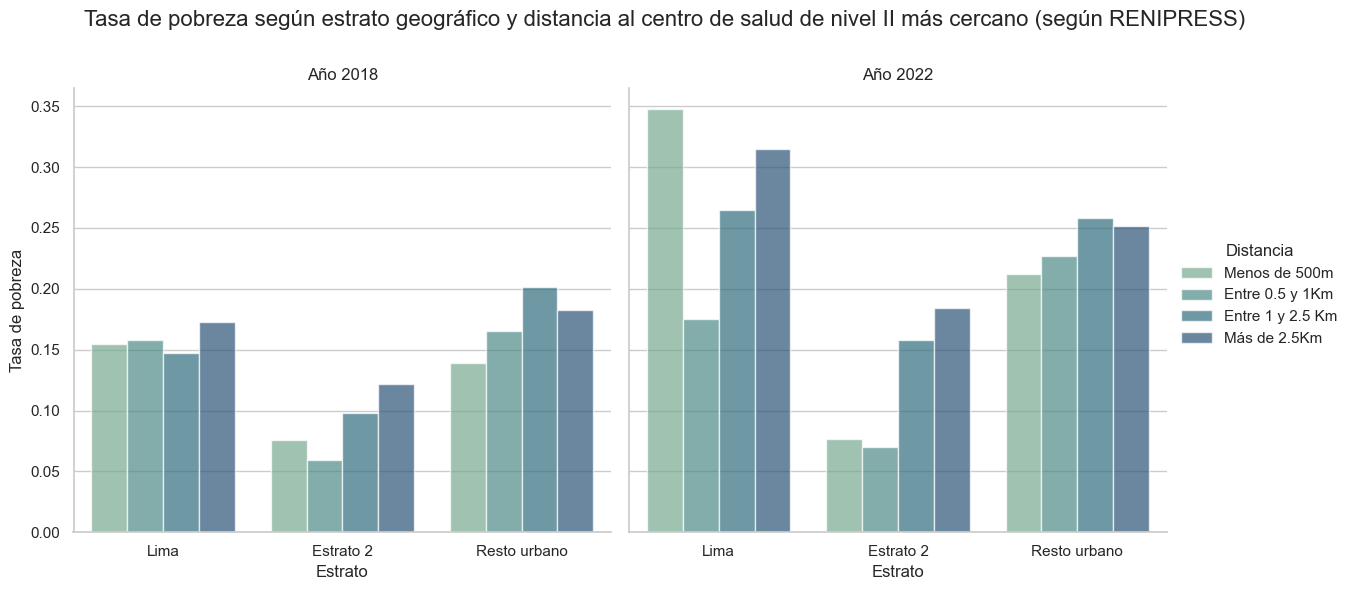

<Figure size 1200x600 with 0 Axes>

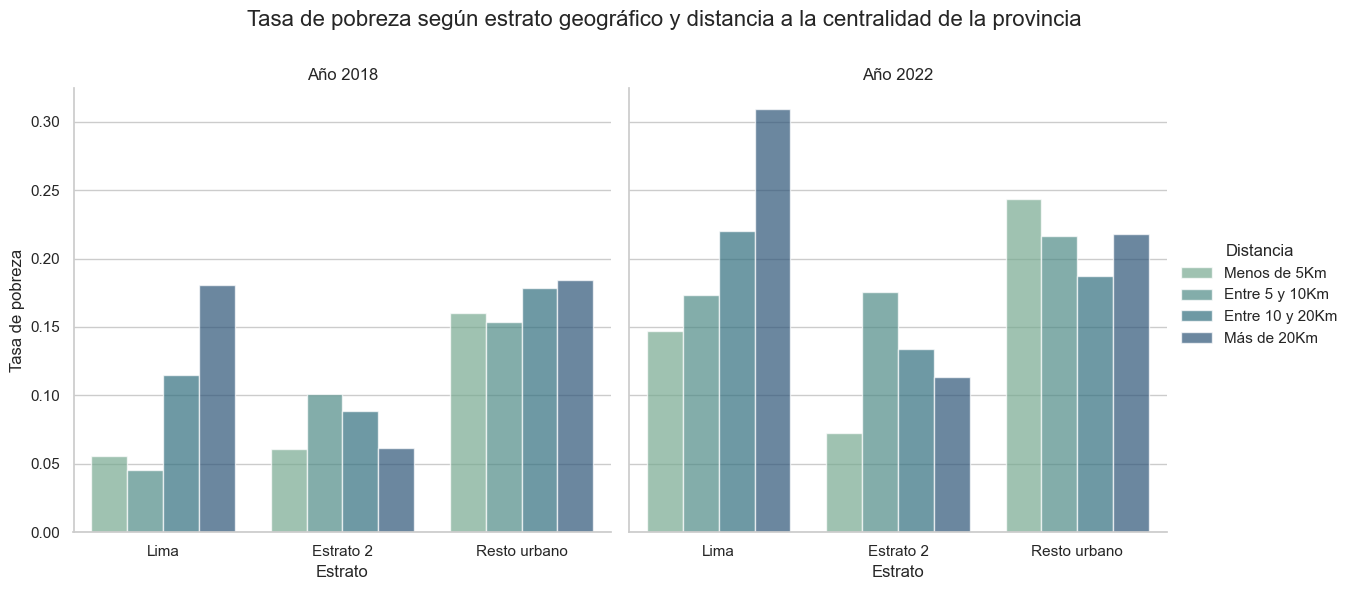

<Figure size 1200x600 with 0 Axes>

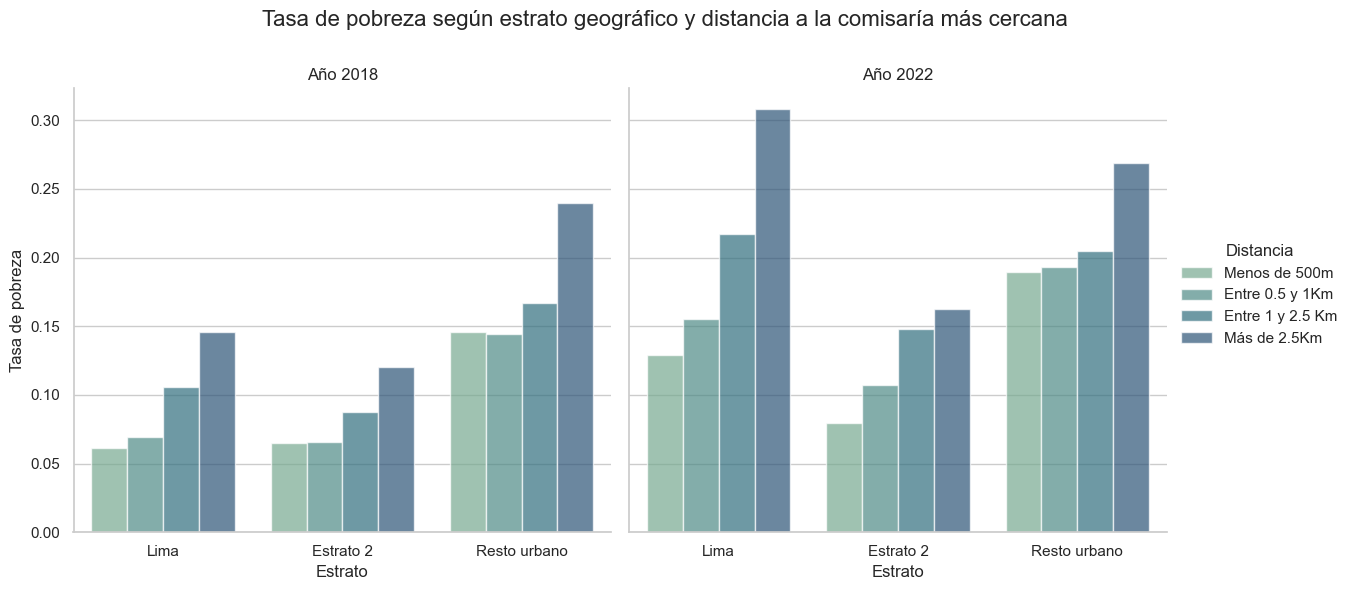

<Figure size 1200x600 with 0 Axes>

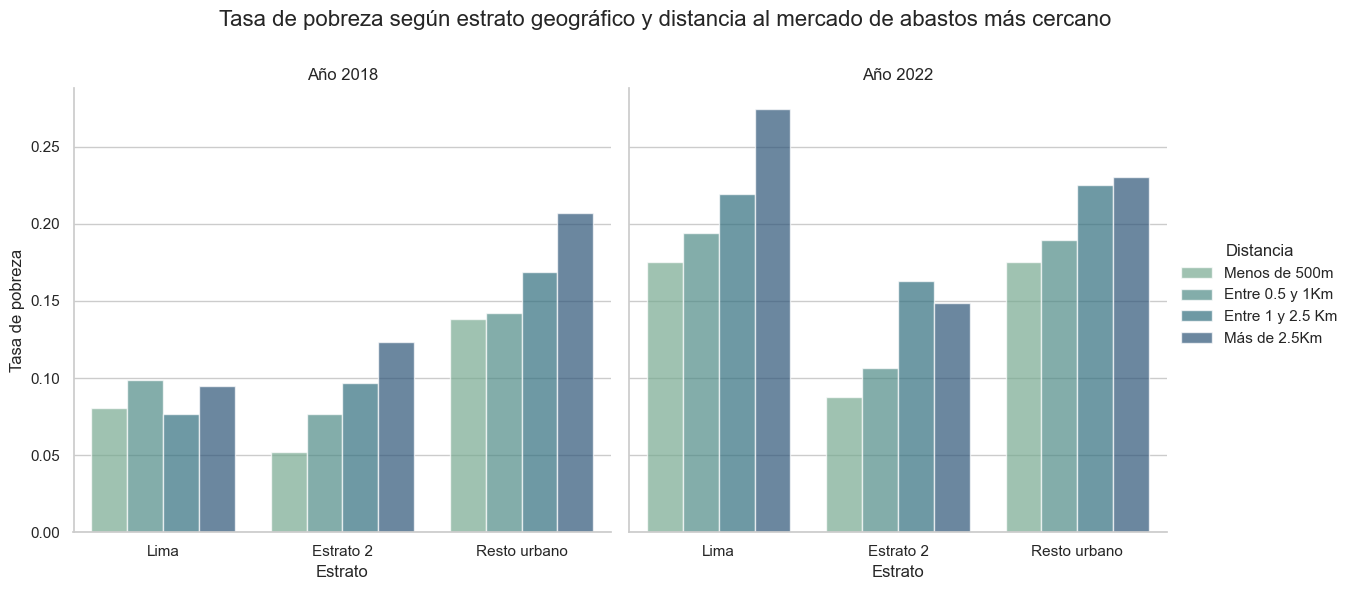

<Figure size 1200x600 with 0 Axes>

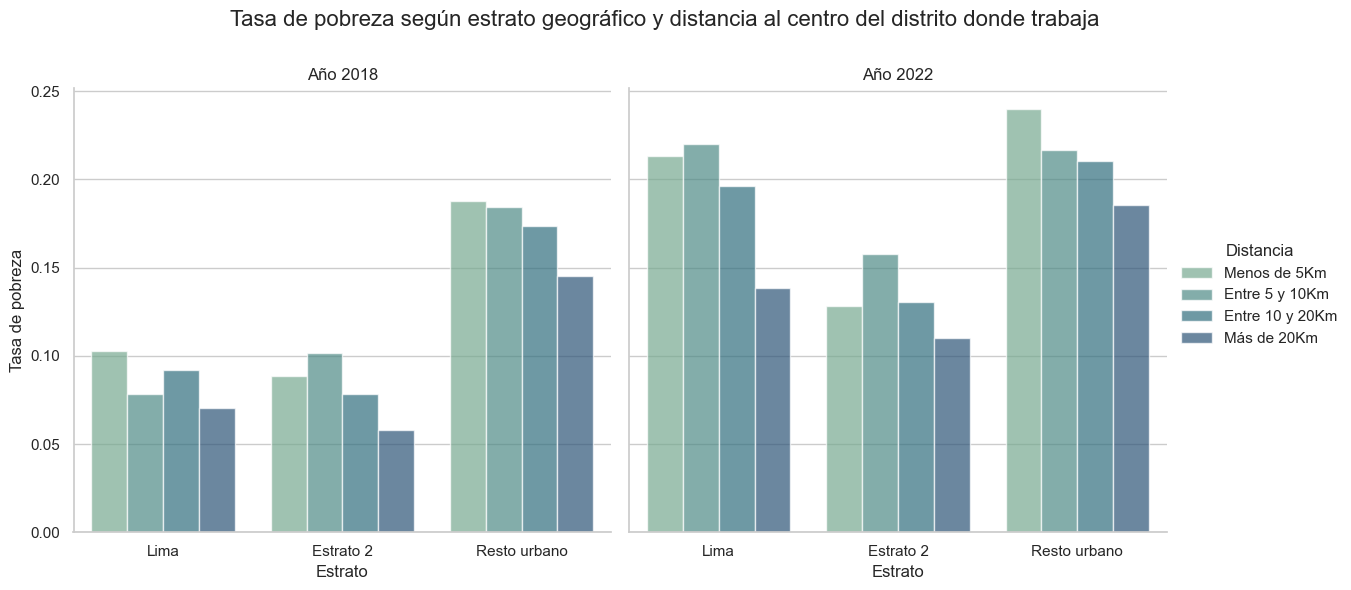

<Figure size 1200x600 with 0 Axes>

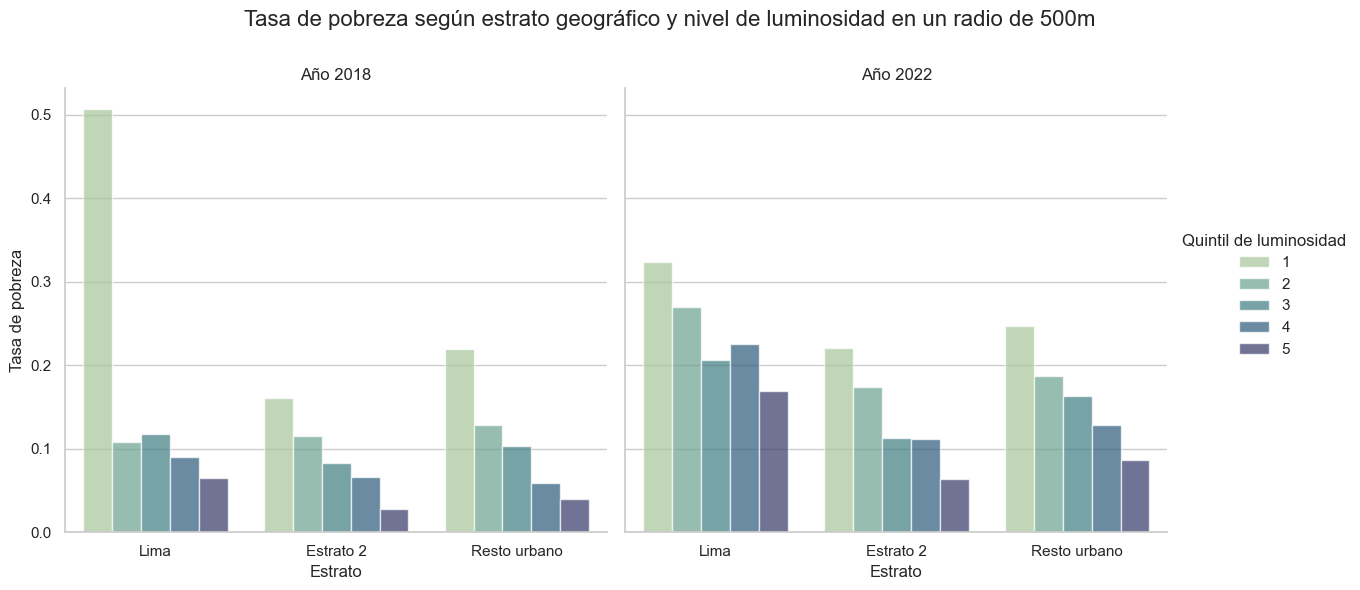

<Figure size 1200x600 with 0 Axes>

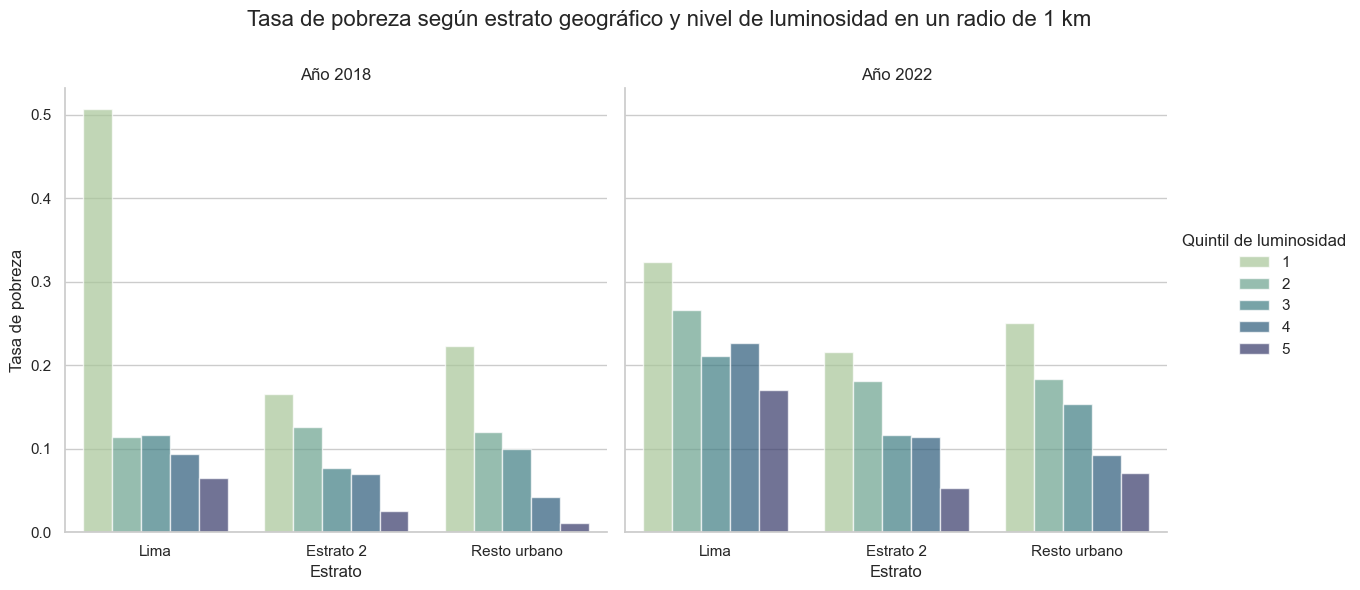

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataframe_names = ['IE', 'CCSS1', 'CCSS_I_II', 'CCSS_I', 'CCSS_II', 'Centro', 'Com', 'Mer', 'Trabajo', 'Rad500', 'Rad1000']
leyendVals= ['Distancia', 'Distancia', 'Distancia', 'Distancia', 'Distancia', 'Distancia', 'Distancia', 'Distancia', 'Distancia', 'Quintil de luminosidad', 'Quintil de luminosidad']
titleVals = ['distancia a la IE más cercana', 'distancia al centro de salud más cercano (según ENAHO)', 'distancia al centro de salud de nivel I o II más cercano (según RENIPRESS)', 'distancia al centro de salud de nivel I más cercano (según RENIPRESS)', 'distancia al centro de salud de nivel II más cercano (según RENIPRESS)', 'distancia a la centralidad de la provincia', 'distancia a la comisaría más cercana', 'distancia al mercado de abastos más cercano', 'distancia al centro del distrito donde trabaja', 'nivel de luminosidad en un radio de 500m', 'nivel de luminosidad en un radio de 1 km']

dictLeyend = dict(zip(dataframe_names, leyendVals))
dictTitles = dict(zip(dataframe_names, titleVals))

os.chdir(r'C:\Users\User\OneDrive - MIGRACIÓN VIDENZA\1. Proyectos\1. Proyectos actuales\23. Artículos PDB\2. PDB - Pobreza Urbana\2. Data\2. Output')

for data in dataframe_names:
    df = merged_dataframes[data]
    cond1 = df['anio'] == 2018
    cond2 = df['anio'] == 2022
    
    df = df[cond1 | cond2 ]
    df_melt = pd.melt(df, id_vars=['anio',f'catDist{data}'], value_vars=['Lima', 'Est2', 'Resto'])
    df_melt.loc[:,'anio'] = df_melt.loc[:,'anio'].astype(int).astype(str)
    df_melt.loc[df_melt['variable']=='Est2','variable'] = "Estrato 2"
    df_melt.loc[df_melt['variable']=='Resto','variable'] = "Resto urbano"
    
    # Setting the figure size
    plt.figure(figsize=(12, 6))
    
    sns.set(style="whitegrid")
    g = sns.FacetGrid(df_melt, col="anio", height=6)
    g.map_dataframe(sns.barplot, x='variable', y='value', hue=f'catDist{data}', errorbar=None,
                    palette="crest", alpha=0.7, dodge=True)
    g.set_axis_labels("Estrato", "Tasa de pobreza")
    g.set_titles(col_template="Año {col_name}", )
    g.add_legend(title = dictLeyend[data])
    g.fig.suptitle(f"Tasa de pobreza según estrato geográfico y {dictTitles[data]}", fontsize=16)
    plt.subplots_adjust(top=0.85)
    g.savefig(f"plot_{data}.png")